## Decision tree  
<font color=black size=4>Table of Contents</font>  
[1. Dataset description](#1.-Dataset-description)  
[2. Imports](#2.-Imports)  
[3. Data loading](#3.-Data-loading)  
[4. Data preparation](#4.-Data-preparation)  
[5. Splitting the dataset](#5.-Splitting-the-dataset)  
[6. Fitting a Decision tree model](#6.-Fitting-a-Decision-tree-model)

### 1. Dataset description  
**Dataset: Credit Approval**  
This dataset concerns credit card applications. Examples represent positive and negative instances of people who were and were not granted credit

- A1:	b, a.  
- A2:	continuous.  
- A3:	continuous.  
- A4:	u, y, l, t.  
- A5:	g, p, gg.  
- A6:	c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.  
- A7:	v, h, bb, j, n, z, dd, ff, o.  
- A8:	continuous.  
- A9:	t, f.  
- A10:	t, f.  
- A11:	continuous.  
- A12:	t, f.  
- A13:	g, p, s.  
- A14:	continuous.  
- A15:	continuous.  
- A16: +,-         (class attribute)

### 2. Imports

In [1]:

import pandas as pd
import ydata_profiling
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay


### 3. Data loading

In [2]:
# set the same names of the columns as in description above

data = pd.read_csv("credit_approve/crx.data", names=[f'A{i}' for i in range(1, 17)])

In [3]:
data.head(7)

A1     A2     A3 A4 A5 A6 A7    A8 A9 A10  A11 A12 A13    A14    A15 A16
0  b  30.83  0.000  u  g  w  v  1.25  t   t    1   f   g  00202      0   +
1  a  58.67  4.460  u  g  q  h  3.04  t   t    6   f   g  00043    560   +
2  a  24.50  0.500  u  g  q  h  1.50  t   f    0   f   g  00280    824   +
3  b  27.83  1.540  u  g  w  v  3.75  t   t    5   t   g  00100      3   +
4  b  20.17  5.625  u  g  w  v  1.71  t   f    0   f   s  00120      0   +
5  b  32.08  4.000  u  g  m  v  2.50  t   f    0   t   g  00360      0   +
6  b  33.17  1.040  u  g  r  h  6.50  t   f    0   t   g  00164  31285   +

### 4. Data preparation

In [4]:
# Missing values are noted as "?", let's replace to NaN
data = data.replace('?', np.NaN)

In [5]:
data.info()

# A2 hasn't numerical type
# A14 has object type and format 00000 - 02000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      678 non-null    object 
 1   A2      678 non-null    object 
 2   A3      690 non-null    float64
 3   A4      684 non-null    object 
 4   A5      684 non-null    object 
 5   A6      681 non-null    object 
 6   A7      681 non-null    object 
 7   A8      690 non-null    float64
 8   A9      690 non-null    object 
 9   A10     690 non-null    object 
 10  A11     690 non-null    int64  
 11  A12     690 non-null    object 
 12  A13     690 non-null    object 
 13  A14     677 non-null    object 
 14  A15     690 non-null    int64  
 15  A16     690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


In [6]:
data['A14'].describe()

count       677
unique      170
top       00000
freq        132
Name: A14, dtype: object

<AxesSubplot: >

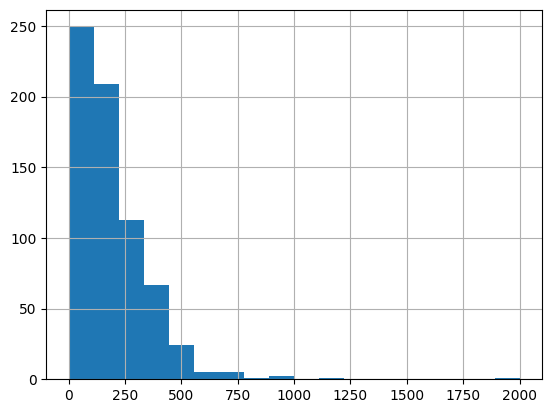

In [7]:
data['A14'].astype('float').hist(bins=18)

# This column definitely should has numerical type

In [8]:
# Transform columns A2 and A14 to float type

data[['A2', 'A14']] = data[['A2', 'A14']].astype('float')


In [9]:
data.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

The following columns will be deleted:  
- A4 and A5 are similar according to correlation table  
- Correlation of A1, A12 ana A14 with A16 (result) are 0.00, 0.00 and 0.03 respectively

In [10]:
data = data.drop(columns=['A1', 'A5', 'A12', 'A14'], axis=1)

In [11]:
# Drop the rows with at least 3 NaN values

data = data.dropna(thresh=(len(data.columns) - 3))
data.shape

(690, 12)

In [12]:
data.isna().sum()

A2     12
A3      0
A4      6
A6      9
A7      9
A8      0
A9      0
A10     0
A11     0
A13     0
A15     0
A16     0
dtype: int64

In [13]:
data.describe(include='object')

A4   A6   A7   A9  A10  A13  A16
count   684  681  681  690  690  690  690
unique    3   14    9    2    2    3    2
top       u    c    v    t    f    g    -
freq    519  137  399  361  395  625  383

In [14]:
# Fill NaN in numerical column A2 (perhaps it is age)
print('median value -', data['A2'].median())
data['A2'] = data['A2'].fillna(data['A2'].median())

median value - 28.46


In [15]:
# Fill NaN in categorical columns A4, A6, A7
print('most frequent values', data[['A4', 'A6', 'A7']].value_counts().index[0])
data = data.apply(lambda x: x.fillna(x.value_counts().index[0]))

most frequent values ('u', 'c', 'v')


In [16]:
# Check NaN
data.isna().sum().sum()

0

Categorical variable encoding  
We should avoid label encoding in Python when it introduces false order to the data, which can, in turn, lead to incorrect conclusions. Tree-based methods (decision trees, Random Forest) can work with categorical data and label encoding. However, for algorithms such as linear regression, models calculating distance metrics between features (k-means clustering, k-Nearest Neighbors) or Artificial Neural Networks (ANN) are one-hot encoding.

In [17]:
labelencoder = LabelEncoder()

data[['A4', 'A6', 'A7', 'A9', 'A10', 'A13', 'A16']] = data[[
      'A4', 'A6', 'A7', 'A9', 'A10', 'A13', 'A16']].apply(labelencoder.fit_transform)
data.head()

# using 'apply' to code seven columns at once

A2     A3  A4  A6  A7    A8  A9  A10  A11  A13  A15  A16
0  30.83  0.000   1  12   7  1.25   1    1    1    0    0    0
1  58.67  4.460   1  10   3  3.04   1    1    6    0  560    0
2  24.50  0.500   1  10   3  1.50   1    0    0    0  824    0
3  27.83  1.540   1  12   7  3.75   1    1    5    0    3    0
4  20.17  5.625   1  12   7  1.71   1    0    0    2    0    0

### 5. Splitting the dataset  
- Splitting the dataset into target and features  
- Splitting the dataset into train and test sets

In [18]:
X = data.copy()    #features
y = X.pop('A16')   #target

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1, train_size=0.8, stratify=y)

### 6. Fitting a Decision tree model

In [20]:
# Function for plotting decision tree and model evaluation

def plot_score(tree, X_train, y_train, X_test, y_test):
    
    # plotting decision tree
    plt.figure(figsize=(25,20))
    plot_tree(tree, feature_names=list(X_train), filled=True)
    plt.show()
    
    # mean accuracy of train data
    score = cross_val_score(tree, X_train, y_train, cv=5)
    print(score.mean(), "- mean accuracy evaluated by cross validation of train data")
    
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)
    
    print()
    print("Basic classification metrics")
    print(classification_report(y_test, y_test_pred))

    # ROC AUC value
    roc_train = roc_auc_score(y_train, y_train_pred)
    roc_test = roc_auc_score(y_test, y_test_pred)
    print(f"ROC AUC на обучающей {roc_train}")
    print(f"ROC AUC на тестовой {roc_test}")
    
    # ROC-curve
    graph = RocCurveDisplay.from_predictions(y_test, y_test_pred, name="test")
    RocCurveDisplay.from_predictions(y_train, y_train_pred, ax=graph.ax_, name="train")
    plt.plot([0, 1], [0, 1], "k--")

- **default parameters**

In [21]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [22]:
print("Target predicted from test data  ", tree.predict(X_test)[:10])
print("Real target                      ", np.array(y_test[:10]))

Target predicted from test data   [0 0 0 0 0 1 0 0 0 1]
Real target                       [1 0 0 0 0 0 0 0 0 1]


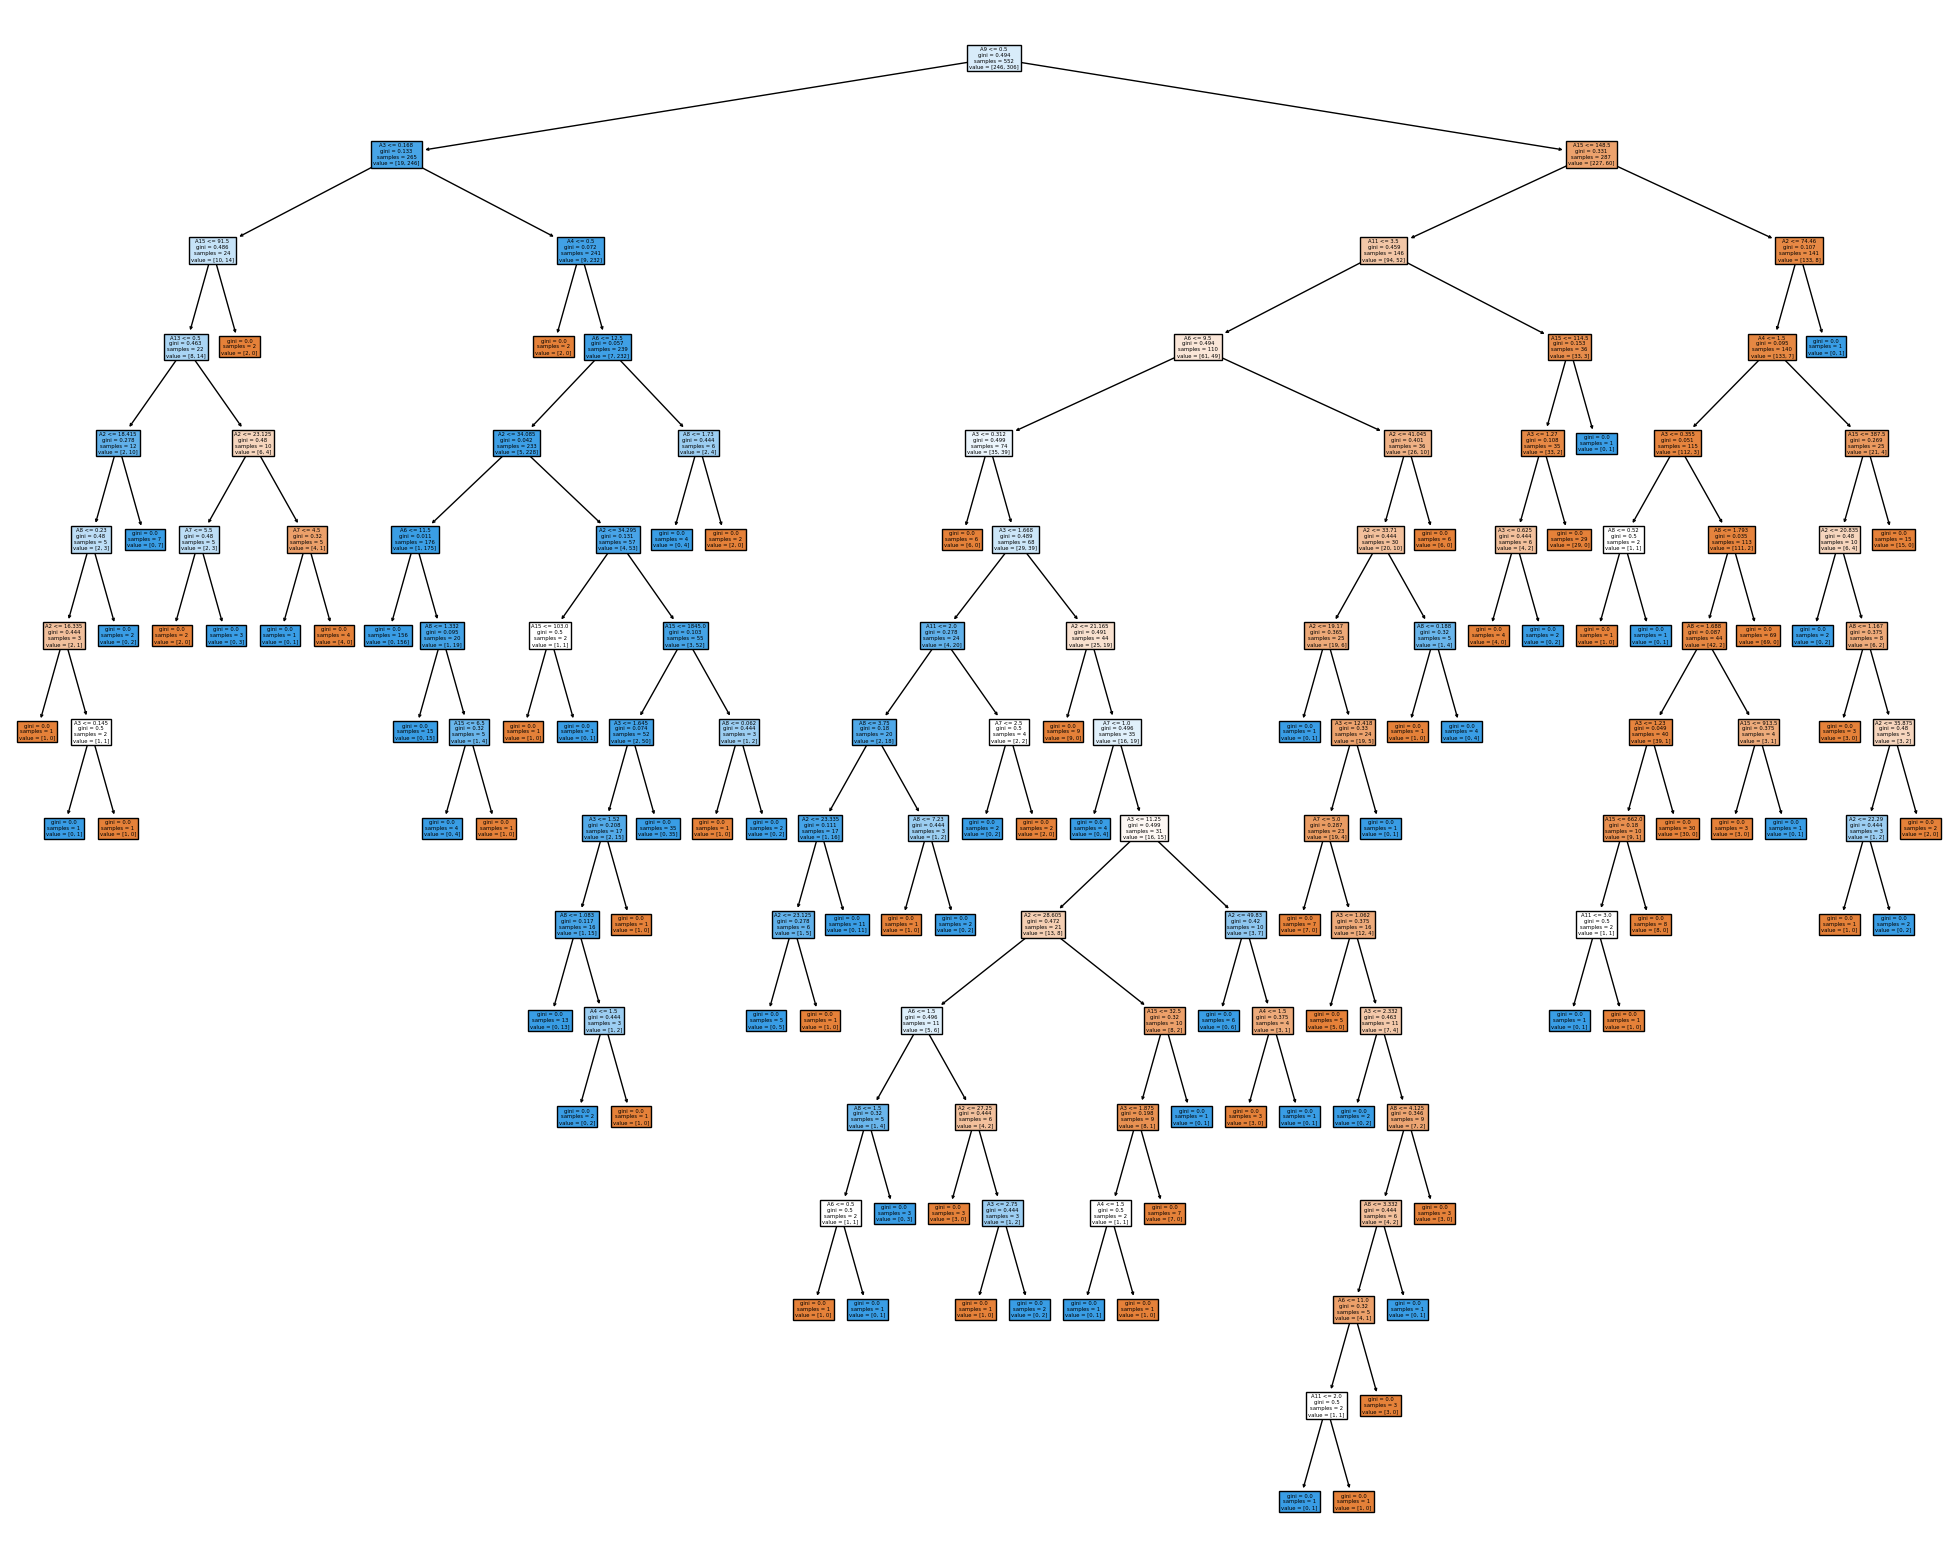

0.8061916461916463 - mean accuracy evaluated by cross validation of train data

Basic classification metrics
              precision    recall  f1-score   support

           0       0.74      0.69      0.71        61
           1       0.77      0.81      0.78        77

    accuracy                           0.75       138
   macro avg       0.75      0.75      0.75       138
weighted avg       0.75      0.75      0.75       138

ROC AUC на обучающей 1.0
ROC AUC на тестовой 0.7468596976793699


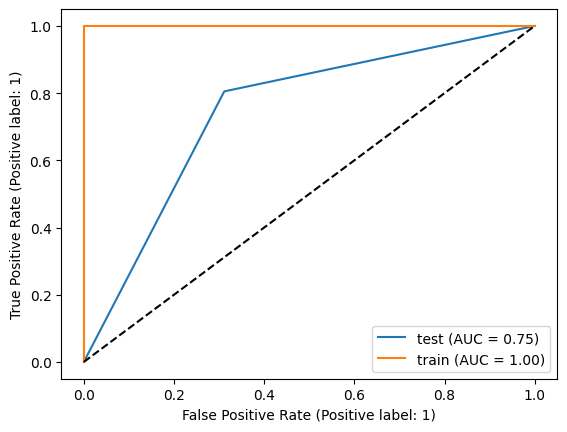

In [23]:

# calling user-defined function
plot_score(tree, X_train, y_train, X_test, y_test)


- **manual tuning of the parameters**

In [24]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=3)
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

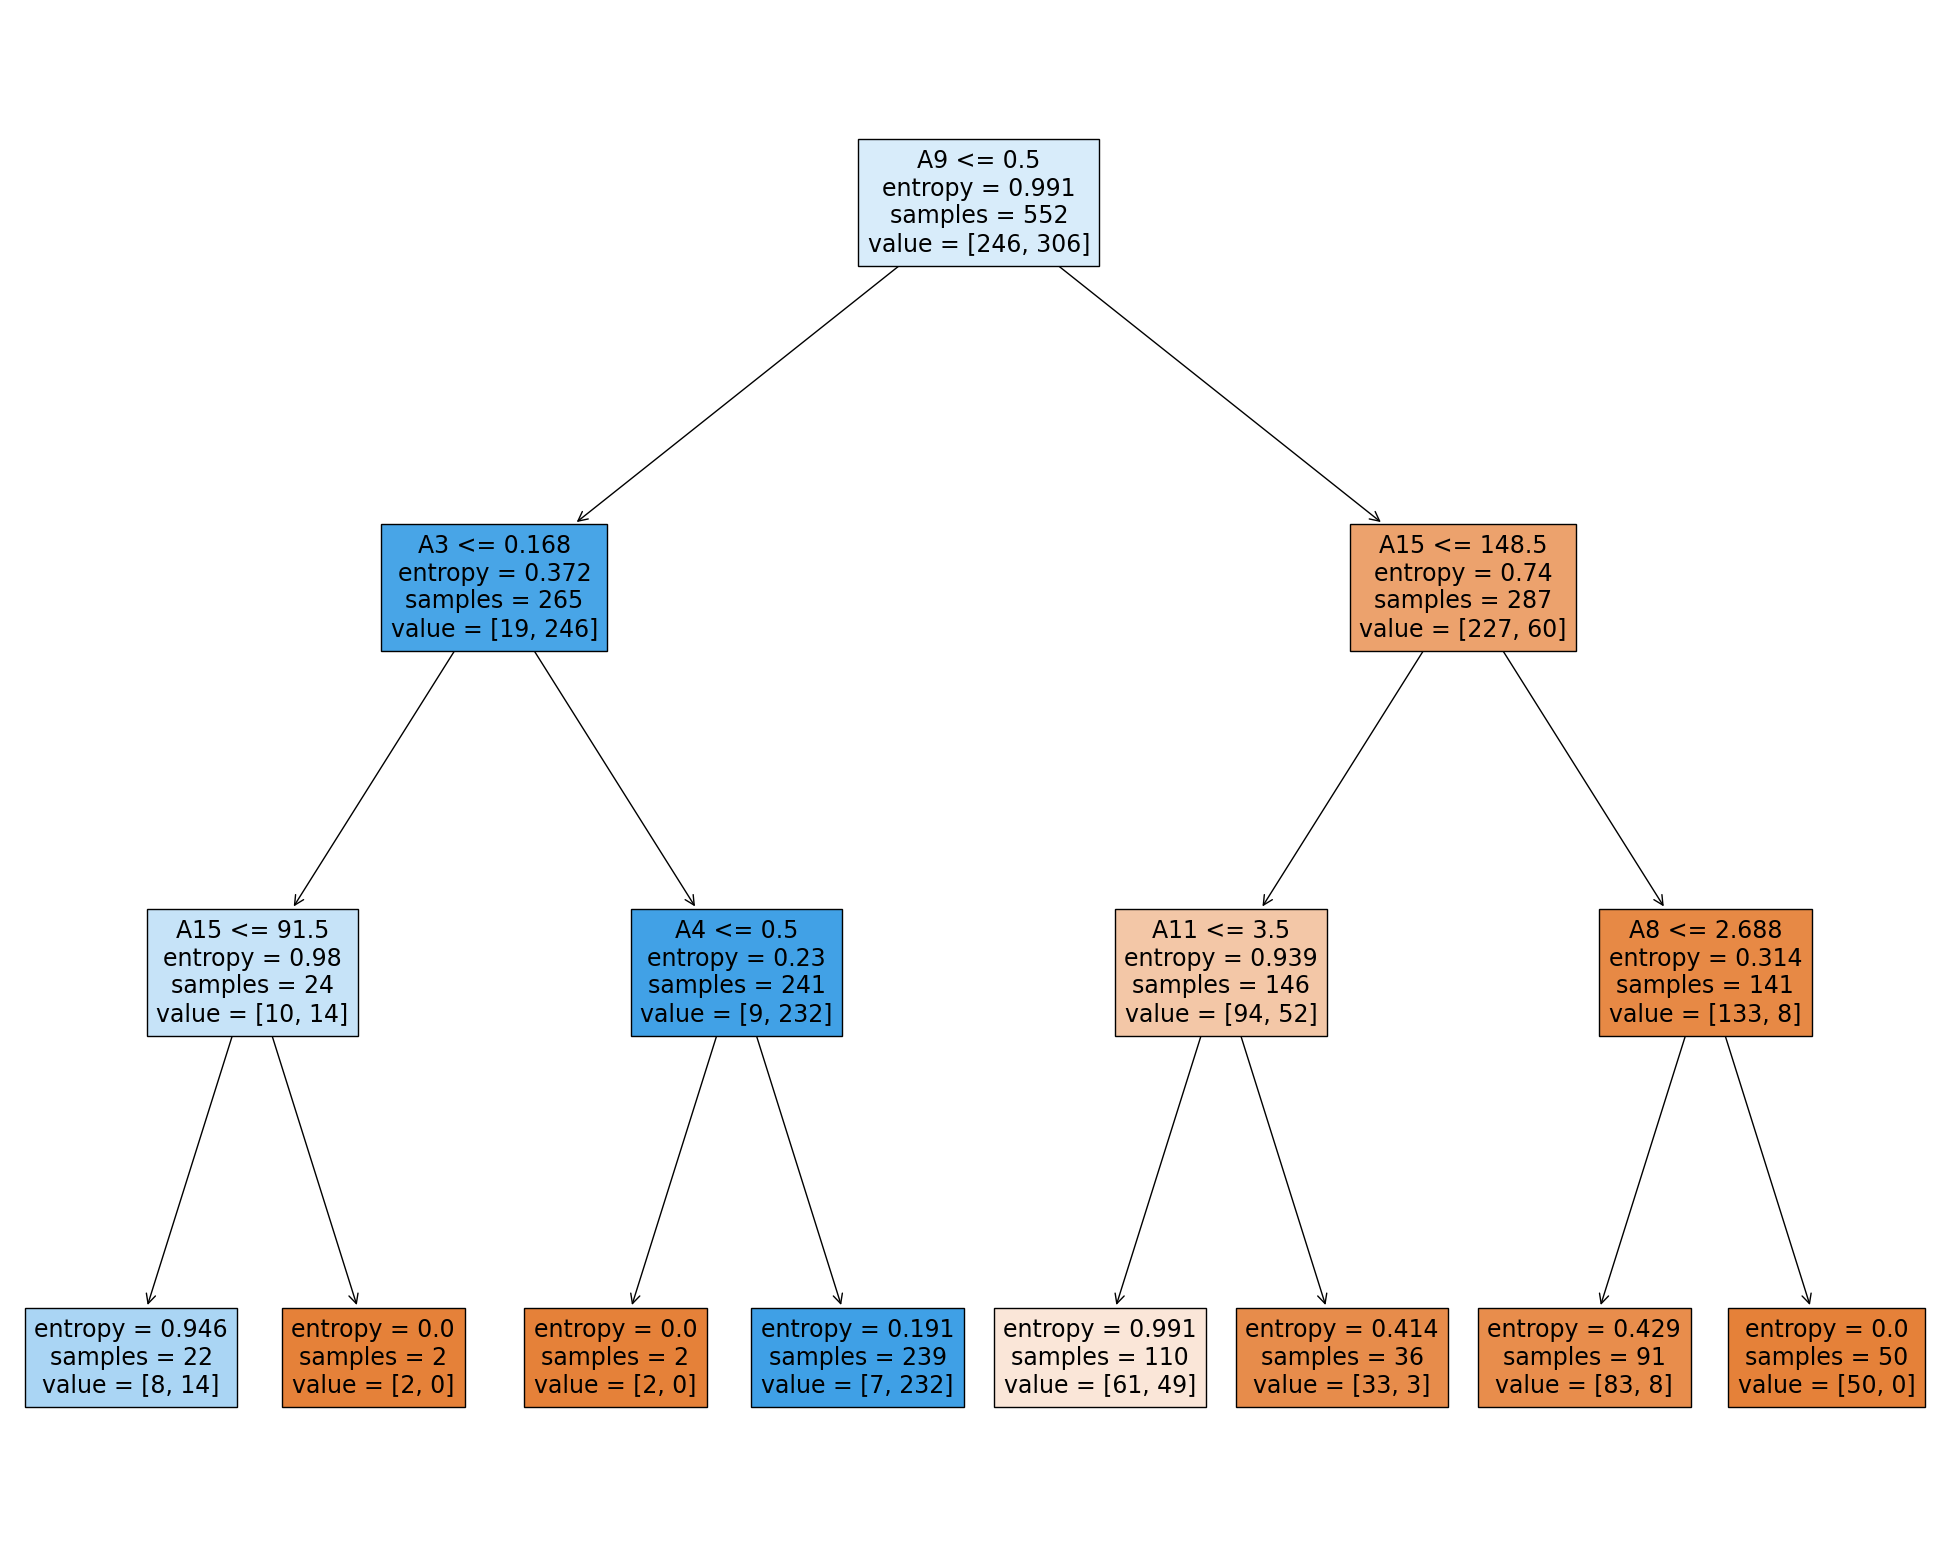

0.8478460278460279 - mean accuracy evaluated by cross validation of train data

Basic classification metrics
              precision    recall  f1-score   support

           0       0.75      0.93      0.83        61
           1       0.94      0.75      0.83        77

    accuracy                           0.83       138
   macro avg       0.84      0.84      0.83       138
weighted avg       0.85      0.83      0.83       138

ROC AUC на обучающей 0.8714729794356767
ROC AUC на тестовой 0.8438364913774751


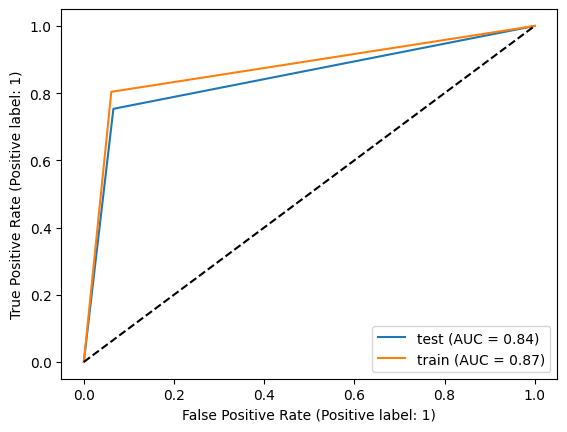

In [25]:
# calling user-defined function
plot_score(tree, X_train, y_train, X_test, y_test)

- **Implementing Grid Search**

In [26]:
parameters = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [3, 4, 5, 6],
            'min_samples_split': [i for i in range(2, 33, 2)],
            'max_features': ["sqrt", "log2", None]
}

In [27]:
grid_search_tree = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5)
grid_search_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18,
                                               20, 22, 24, 26, 28, 30, 32]})

In [28]:
grid_search_tree.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'log2',
 'min_samples_split': 10}

In [29]:
tree = grid_search_tree.best_estimator_    # best decision tree

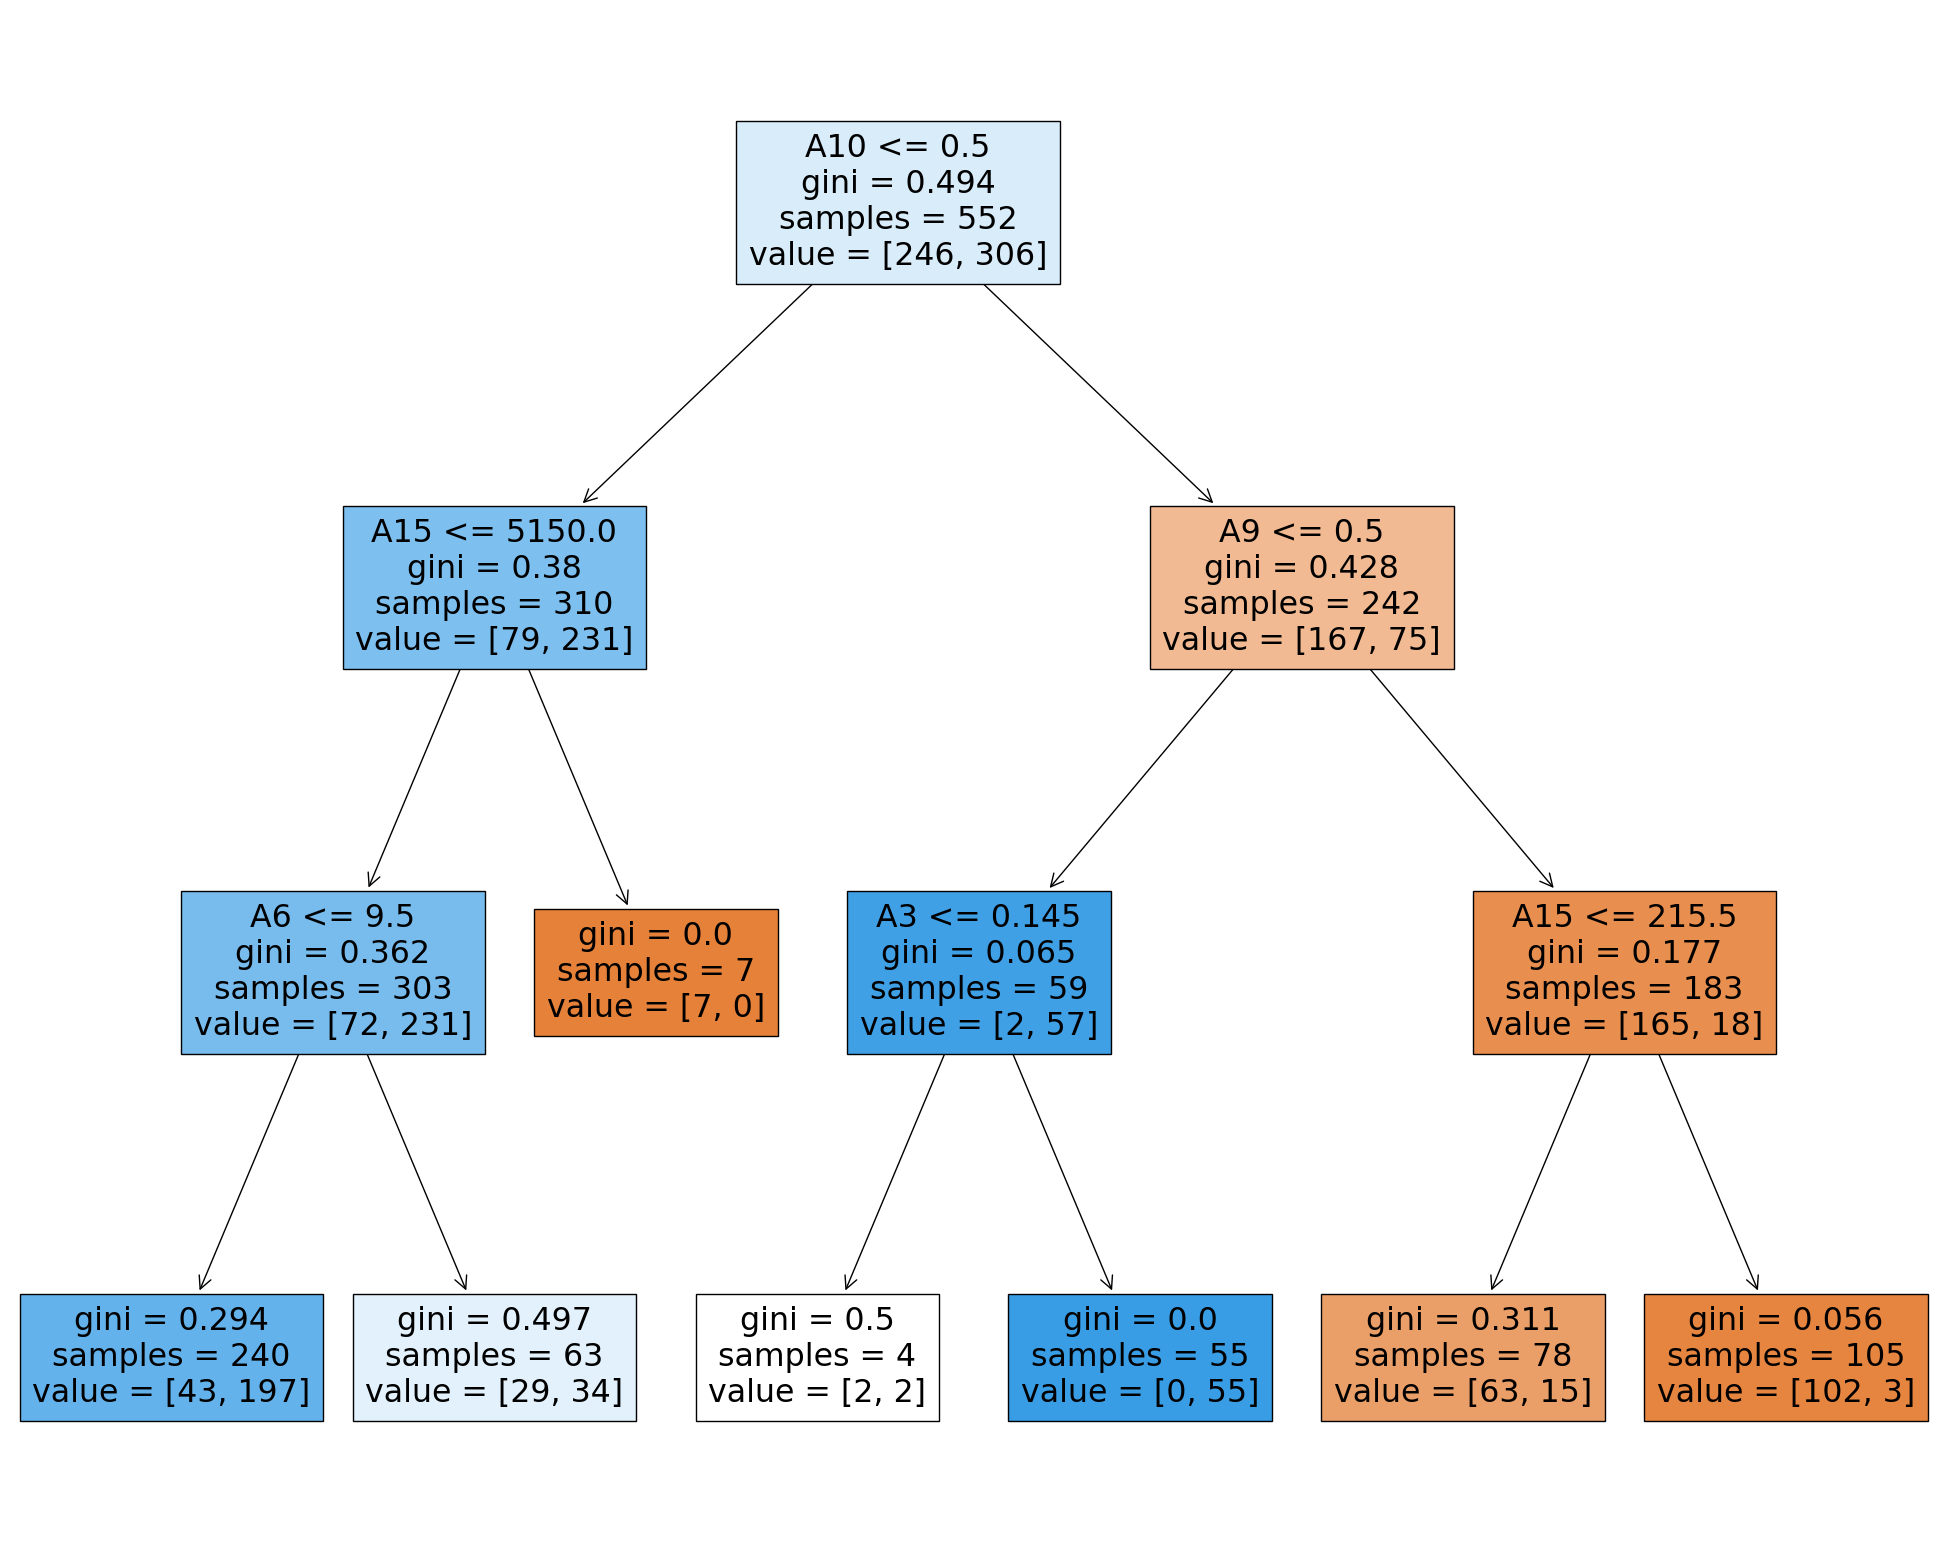

0.798935298935299 - mean accuracy evaluated by cross validation of train data

Basic classification metrics
              precision    recall  f1-score   support

           0       0.91      0.70      0.80        61
           1       0.80      0.95      0.87        77

    accuracy                           0.84       138
   macro avg       0.86      0.83      0.83       138
weighted avg       0.85      0.84      0.84       138

ROC AUC на обучающей 0.8209787980232743
ROC AUC на тестовой 0.8264849904194166


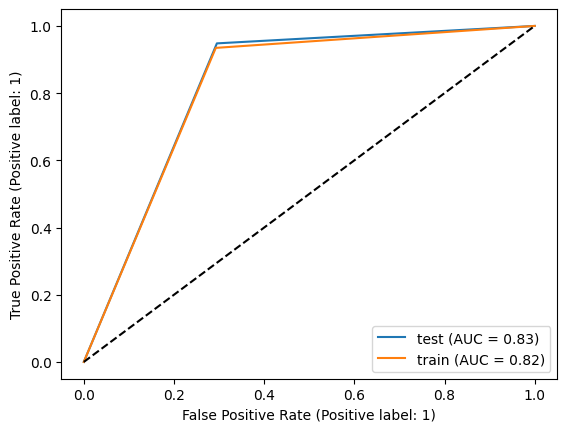

In [30]:
# calling user-defined function
plot_score(tree, X_train, y_train, X_test, y_test)

In [43]:
features = pd.Series(tree.feature_importances_, list(X))
features.sort_values(ascending=False)

A9     0.484117
A10    0.371010
A15    0.074596
A6     0.056842
A3     0.013434
A2     0.000000
A4     0.000000
A7     0.000000
A8     0.000000
A11    0.000000
A13    0.000000
dtype: float64

Thus, to avoid overfitting we have obtained Area Under the ROC 0.84 and 0.83 by manual tuning of the parameters and implementing Grid Search.